# Imports

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [4]:
df_train_raw = pd.read_parquet('data/train.parquet')

EDA has been done beforehand, not shown here

# Step 1: Aggregation per user and per day

In [5]:
warnings.filterwarnings('ignore')

def step_1_daily_aggregation(df):
    """
    Transforms raw logs into a Daily User Activity df (grouped by userid and day)

    Logic:
    1. Converts timestamps to daily dates
    2. Filter out the target event
    3. Feature engineers some specific page events (NextSong, Errors, etc.) into features
    4. Aggregates daily metrics like listening time or session count
    5. Encodes the 'level' column (paid/free) to binary (paid=1, free=0)
    """

    # 1.
    df['date'] = pd.to_datetime(df['ts'], unit='ms').dt.floor('D')

    # 2.
    df_features = df[df['page'] != 'Cancellation Confirmation']

    # 3.
    relevant_pages = [
        'NextSong', 'Thumbs Up', 'Thumbs Down',
        'Error', 'Add Friend', 'Roll Advert', 'Upgrade', 'Downgrade',
        'Add to Playlist', 'Settings', 'Help'
    ]
    df_relevant = df_features[df_features['page'].isin(relevant_pages)]

    daily_page_counts = df_relevant.pivot_table(
        index=['userId', 'date'],
        columns='page',
        values='ts',
        aggfunc='count',
        fill_value=0
    )
    daily_page_counts.columns = [f'daily_{col.replace(" ", "")}' for col in daily_page_counts.columns]

    # 4.
    daily_stats = df_features.groupby(['userId', 'date']).agg({
        'length': 'sum',              # Listening time
        'sessionId': 'nunique',       # Session count
        'level': 'last',              # Paid/Free
        'registration': 'max',        # Registration time
        'artist': 'nunique',          # Diversity
    }).rename(columns={
        'length': 'daily_listen_time',
        'sessionId': 'daily_sessions',
        'level': 'status_level',
        'artist': 'daily_unique_artists'})

    # merging both df
    df_daily = pd.concat([daily_page_counts, daily_stats], axis=1).reset_index()

    # 5.
    df_daily['is_paid'] = df_daily['status_level'].apply(lambda x: 1 if x == 'paid' else 0)
    df_daily.drop('status_level', axis=1, inplace=True)

    return df_daily

In [6]:
df_daily_train = step_1_daily_aggregation(df_train_raw)
print("Step 1 done")

Step 1 done


In [7]:
df_daily_train.head()

,userId,date,daily_AddFriend,daily_AddtoPlaylist,daily_Downgrade,daily_Error,daily_Help,daily_NextSong,daily_RollAdvert,daily_Settings,daily_ThumbsDown,daily_ThumbsUp,daily_Upgrade,daily_listen_time,daily_sessions,registration,daily_unique_artists,is_paid
0,1000025,2018-10-02,3.0,2.0,1.0,0.0,1.0,95.0,2.0,0.0,2.0,5.0,1.0,24922.31447,2,2018-07-10 09:30:08,91,1
1,1000025,2018-10-03,6.0,13.0,2.0,0.0,2.0,317.0,1.0,1.0,3.0,21.0,0.0,77571.72247,1,2018-07-10 09:30:08,282,1
2,1000025,2018-10-04,0.0,5.0,3.0,0.0,1.0,201.0,0.0,0.0,3.0,12.0,0.0,49228.60436,1,2018-07-10 09:30:08,191,1
3,1000025,2018-10-05,0.0,1.0,2.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,5720.83247,1,2018-07-10 09:30:08,22,1
4,1000025,2018-10-06,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,888.24027,1,2018-07-10 09:30:08,3,1


# Step 2: Feature Engineering

In [8]:
def step_2_feature_engineering(df_daily):
    """
    Generates Time-Series Features and other signals. Since dataset is only made of
    less than 2 months worth of logs, the rolling windows are very short

    Logic:
    1. Sorts our df_daily data by User and Date
    2. Computes Rolling Windows (7d, 30d) for short-term trends
    3. Calculates Lifetime Snapshots (Expanding Mean/Std) for long-term context
    4. Computes complex signals: recency (days since active), diversity, and ratios
    5. Cleans up some useless features
    """

    # 1.
    df_daily = df_daily.sort_values(['userId', 'date'])

    # 2.
    features_to_roll = [
        'daily_NextSong', 'daily_Error', 'daily_ThumbsDown', 'daily_ThumbsUp',
        'daily_RollAdvert', 'daily_listen_time', 'daily_AddFriend', 'daily_Help',
        'daily_AddtoPlaylist', 'daily_Downgrade', 'daily_Upgrade', 'daily_sessions',
        'daily_unique_artists'
    ]

    # 3.
    for col in features_to_roll:
        grouped = df_daily.groupby('userId')[col]

        # we always shift the data for 1 day to make sure we correctly avoid
        # data leakage from the future

        # short-term trends (rolling)
        df_daily[f'{col}_last_7d'] = grouped.transform(lambda x: x.shift(1).rolling(7, min_periods=1).sum())
        df_daily[f'{col}_last_30d'] = grouped.transform(lambda x: x.shift(1).rolling(30, min_periods=1).sum())

        # lifetime stats
        df_daily[f'{col}_lifetime_avg'] = grouped.transform(lambda x: x.shift(1).expanding().mean())
        df_daily[f'{col}_lifetime_std'] = grouped.transform(lambda x: x.shift(1).expanding().std().fillna(0))

        # scaling 30d trend to compare fairly to 7d
        avg_30d_scaled = (df_daily[f'{col}_last_30d'] / 30) * 7
        df_daily[f'{col}_trend'] = df_daily[f'{col}_last_7d'] / (avg_30d_scaled + 1e-5)
        # eps added to avoid dividing by 0

    # 4. signals feature engineering
    # diversity = unique artists(Lifetime)
    df_daily['lifetime_unique_artists'] = df_daily.groupby('userId')['daily_unique_artists'].transform(
            lambda x: x.shift(1).expanding().sum())

    # recency (days since last active)
    df_daily['prev_date'] = df_daily.groupby('userId')['date'].shift(1)
    df_daily['days_since_last_active'] = (df_daily['date'] - df_daily['prev_date']).dt.days
    df_daily['days_since_last_active'] = df_daily['days_since_last_active'].fillna(0)
    df_daily.drop('prev_date', axis=1, inplace=True)

    # number of days since registration
    reg_date = pd.to_datetime(df_daily['registration']).dt.floor('D')
    df_daily['days_since_reg'] = (df_daily['date'] - reg_date).dt.days

    # Ratios
    # ad Ratio
    df_daily['ratio_ads_per_song'] = df_daily['daily_RollAdvert_last_30d'] / (df_daily['daily_NextSong_last_30d'] + 1)

    # downgrade propensity
    if 'daily_ThumbsDown_last_30d' in df_daily.columns and 'daily_ThumbsUp_last_30d' in df_daily.columns:
        total_thumbs = df_daily['daily_ThumbsDown_last_30d'] + df_daily['daily_ThumbsUp_last_30d']
        df_daily['downgrade_propensity'] = df_daily['daily_ThumbsDown_last_30d'] / (total_thumbs + 1)

    # 5. cleanup
    cols_to_drop = ['raw_agent', 'userAgent', 'summary', 'artist']
    for c in cols_to_drop:
        if c in df_daily.columns:
            df_daily.drop(c, axis=1, inplace=True)

    return df_daily.fillna(0)

In [9]:
df_features_train = step_2_feature_engineering(df_daily_train)
print("Step 2 done")

Step 2 done


# Step 3: Regroup dataset for a static target (1 row per user)

In [ ]:
def step_3_define_static_target(df_features, df_raw_logs):
    """
    Constructs the training dataset and binary target for churn prediction, applying
    Random Negative Sampling to prevent survivorship bias.

    Logic:
    1. Identifies churners based on the 'Cancellation Confirmation' event.
    2. Strategies for Feature Snapshots (Point-in-Time Correctness):
    - Churners (Class 1): Uses the last active day (moment of churn) as the snapshot.
    - Non-Churners (Class 0): Selects a RANDOM active day from their history as the snapshot.
    (This prevents the model from learning that "long history" automatically implies "safe").
    3. Assigns binary labels: 1 for churners, 0 for non-churners.
    """

    # 1.
    # Split into two groups
    churn_users = df_raw_logs[df_raw_logs['page'] == 'Cancellation Confirmation']['userId'].unique()
    df_churners = df_features[df_features['userId'].isin(churn_users)]
    df_non_churners = df_features[~df_features['userId'].isin(churn_users)]

    # 2. 3.
    # Churners: Take the last day (The moment before churn)
    # this captures the trends leading up to their final moment
    final_churn = df_churners.sort_values('date').groupby('userId').tail(1)
    final_churn['target_churn'] = 1

    # Non-Churners: Pick a RANDOM day from their history
    # This prevents the model from relying on "Max Days" as a proxy for safety
    final_non_churn = df_non_churners.groupby('userId').sample(n=1, random_state=5)
    final_non_churn['target_churn'] = 0

    print(f"class balance: {final_churn['target_churn'].value_counts().to_dict()}")
    print(f"class balance: {final_non_churn['target_churn'].value_counts().to_dict()}")

    return pd.concat([final_churn, final_non_churn])

In [11]:
df_final_train = step_3_define_static_target(df_features_train, df_train_raw)
print(df_final_train.shape)
print("Step 3 done")

class balance: {1: 4271}
class balance: {0: 14869}
(19140, 89)
Step 3 done


In [12]:
df_final_train.head()

,userId,date,daily_AddFriend,daily_AddtoPlaylist,daily_Downgrade,daily_Error,daily_Help,daily_NextSong,daily_RollAdvert,daily_Settings,...,daily_unique_artists_last_30d,daily_unique_artists_lifetime_avg,daily_unique_artists_lifetime_std,daily_unique_artists_trend,lifetime_unique_artists,days_since_last_active,days_since_reg,ratio_ads_per_song,downgrade_propensity,target_churn
192232,1947971,2018-10-01,5.0,5.0,1.0,0.0,3.0,225.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,41,0.0,0.0,1
148056,1722849,2018-10-01,0.0,1.0,0.0,0.0,0.0,26.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,32,0.0,0.0,1
135016,1661761,2018-10-01,0.0,0.0,0.0,0.0,0.0,16.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10,0.0,0.0,1
184912,1912369,2018-10-01,0.0,0.0,0.0,0.0,0.0,20.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,0.0,1
105816,1517159,2018-10-01,3.0,5.0,1.0,0.0,0.0,116.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,140,0.0,0.0,1


# Step 4: First model training

In [13]:
def train_model(df_final):
    """
    Trains the XGBoost Classifier.

    Logic:
    1. Drops metadata columns (userId, date) to isolate features
    2. Performs a Stratified Random Split (80/20) because rows are independent users
    3. Calculates a dynamic hyperparam `scale_pos_weight` to handle class imbalance
    4. Trains the model and outputs Validation Report, AUC, and Feature Importance
    """

    # 1.
    cols_to_drop = ['userId', 'date', 'registration', 'target_churn']

    X = df_final.drop(columns=cols_to_drop)
    y = df_final['target_churn']

    # 2.
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y)

    # 3.
    pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
    print(f"Calculated scale_pos_weight: {pos_weight:.2f}")

    # let's use common standard hyperparams first before our future tuning
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        scale_pos_weight=pos_weight,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=5
    )

    # 4.
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    print("\n- Validation Results -")
    print(classification_report(y_val, y_pred))
    print(f"AUC-ROC score: {roc_auc_score(y_val, y_proba):.4f}")

    importance_dict = model.get_booster().get_score(importance_type='weight')
    importance_df = (
    pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
      .sort_values('importance', ascending=False)
    )

    xgb.plot_importance(model, max_num_features=25, importance_type='weight')
    plt.title("Features Importance (Top)")
    plt.show();

    return model, importance_dict

Calculated scale_pos_weight: 3.48

- Validation Results -
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      2974
           1       0.51      0.76      0.61       854

    accuracy                           0.78      3828
   macro avg       0.72      0.78      0.73      3828
weighted avg       0.83      0.78      0.80      3828

AUC-ROC score: 0.8614


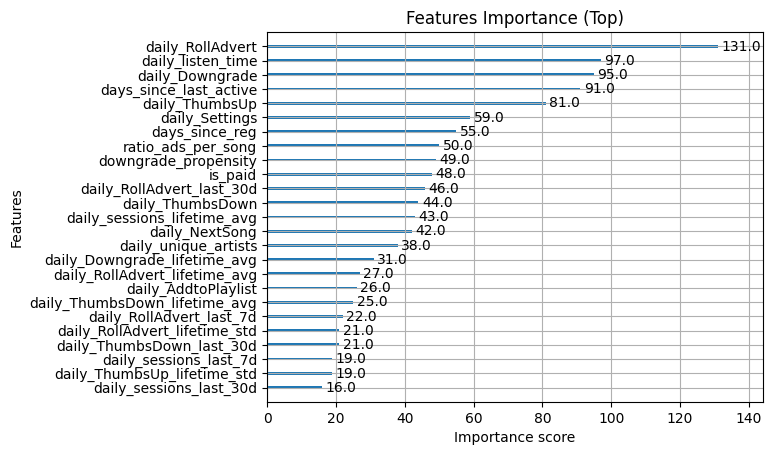

In [14]:
trained_model = train_model(df_final_train)[0]

# Step 5: Training optimized model with RandomizedSearch & Feature Selection

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

def train_optimized_model(df_final):
    """
    Now trains and optimizes the XGBoost Classifier with automated
    Feature Selection and Hyperparameter Tuning.

    Logic:
    1. Splits Data: Performs Stratified Random Split (80/20).
    2. Feature Selection: Fits a base XGBoost model and uses `SelectFromModel` to
       aggressively prune weak features (threshold = 0.5 * mean importance).
    3. Hyperparameter Tuning: Runs `RandomizedSearchCV` on the surviving features
       to optimize Depth, Learning Rate, Imbalance Weight, and Regularization (L1/L2).
    4. Evaluation: Outputs optimal params, Classification Report, AUC, and an
       Importance DataFrame for the final model.
    5. Generate our optimized features importance dataframe
    """

    # 1.
    cols_to_drop = ['userId', 'date', 'registration', 'target_churn']

    X = df_final.drop(columns=cols_to_drop)
    y = df_final['target_churn']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y)

    # 2. automated feature selection
    print("--> running feature selection (dropping noise)")
    selector_model = xgb.XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        scale_pos_weight=3.5,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=5
    )

    selector_model.fit(X_train, y_train)

    # Select features > 0.5 * Mean Importance (Aggressive pruning of noise)
    selection = SelectFromModel(selector_model, threshold='0.5*mean', prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_val = selection.transform(X_val)

    # Recover names of kept features for reporting
    feature_idx = selection.get_support()
    feature_names = X_train.columns[feature_idx].tolist()
    print(f"dropped {X_train.shape[1] - len(feature_names)} features.")
    print(f"kept {len(feature_names)} features.")

    # 3. hyperparams tuning
    print("\n--> running random search (with regularization)")

    param_grid = {
        'max_depth': [3, 4, 5],   # keep shallow trees to prevent overfitting
        'n_estimators': [100, 200],
        'subsample': [0.7, 0.8, 0.9],        # Row sampling
        'colsample_bytree': [0.6, 0.8],      # Feature sampling
        'scale_pos_weight': [8, 10, 12],
        'reg_alpha': [0, 0.1, 1.0, 5.0],     # L1 Regularization (Lasso-like)
        'reg_lambda': [1.0, 5.0, 10.0],      # L2 Regularization (Ridge-like)
        'gamma': [0, 1, 3]                   # Min loss reduction to split
    }

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        random_state=5)

    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=50,
        scoring='roc_auc',   # Optimize for AUC
        cv=5,
        verbose=1,
        random_state=5,
        n_jobs=-1
    )

    random_search.fit(select_X_train, y_train)

    # 4. Evaluation
    best_model = random_search.best_estimator_
    print(f"\n --> best params: {random_search.best_params_}")

    y_pred = best_model.predict(select_X_val)
    y_prob = best_model.predict_proba(select_X_val)[:, 1]

    print("\n- Final Optimized Results -")
    print(classification_report(y_val, y_pred))
    print(f"AUC-ROC Score: {roc_auc_score(y_val, y_prob):.4f}")

    xgb.plot_importance(best_model, max_num_features=10, importance_type='weight')
    plt.title("Top Features (Optimized)")
    plt.show();

    # 5. Generate importance feature dataframe
    importance_dict = best_model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
    importance_df = importance_df.sort_values('importance', ascending=False)

    return best_model, feature_names, importance_df

--> running feature selection (dropping noise)
dropped 38 features.
kept 47 features.

--> running random search (with regularization)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

 --> best params: {'subsample': 0.9, 'scale_pos_weight': 8, 'reg_lambda': 10.0, 'reg_alpha': 1.0, 'n_estimators': 100, 'max_depth': 3, 'gamma': 1, 'colsample_bytree': 0.6}

- Final Optimized Results -
              precision    recall  f1-score   support

           0       0.95      0.62      0.75      2974
           1       0.41      0.89      0.56       854

    accuracy                           0.68      3828
   macro avg       0.68      0.76      0.66      3828
weighted avg       0.83      0.68      0.71      3828

AUC-ROC Score: 0.8603


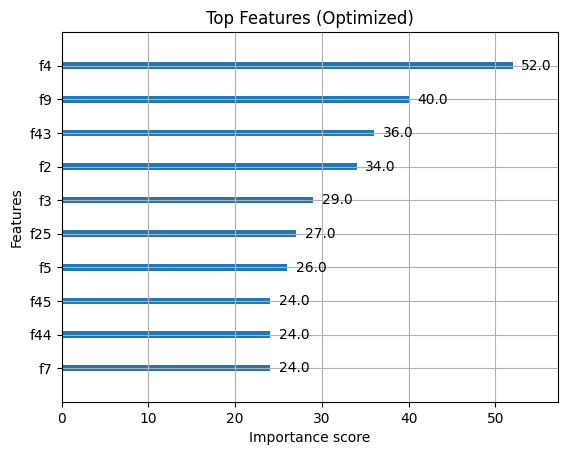

In [16]:
optimized_model, final_features, final_importance_df = train_optimized_model(df_final_train)

# Step 6: Fine-tuning model with GridSearch

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

def train_fine_tuned_model(df_final):
    """
    Now performs GridSearch Fine-Tuning.

    Logic:
    1. Splits Data: Performs Stratified Random Split (80/20).
    2. Feature Selection: Fits a base XGBoost model and uses `SelectFromModel` to
       aggressively prune weak features (threshold = 0.5 * mean importance).
    3. Hyperparameter Tuning: Runs `RandomizedSearchCV` on the surviving features
       to optimize Depth, Learning Rate, Imbalance Weight, and Regularization (L1/L2).
    4. Evaluation: Outputs optimal params, Classification Report, AUC, and an
       Importance DataFrame for the final model.
    5. Generate our optimized features importance dataframe
    """

    # 1.
    cols_to_drop = ['userId', 'date', 'registration', 'target_churn']

    X = df_final.drop(columns=cols_to_drop)
    y = df_final['target_churn']

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=5, stratify=y)

    # 2. automated feature selection
    print("--> running feature selection (dropping noise)")
    selector_model = xgb.XGBClassifier(
        objective='binary:logistic', n_estimators=100, max_depth=3, scale_pos_weight=3.0,
        reg_lambda=10.0, reg_alpha=1.0, gamma=1, colsample_bytree=0.6, subsample=0.9,
        eval_metric='logloss', use_label_encoder=False, random_state=5
    )

    selector_model.fit(X_train, y_train)

    # Feature Selection
    selection = SelectFromModel(selector_model, threshold='0.5*mean', prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_val = selection.transform(X_val)

    # Recover names of kept features for reporting
    feature_idx = selection.get_support()
    feature_names = X_train.columns[feature_idx].tolist()
    print(f"dropped {X_train.shape[1] - len(feature_names)} features.")
    print(f"kept {len(feature_names)} features.")

    # 3. hyperparams tuning
    print("\n--> running grid search (with regularization)")

    # we lock in params which turned great during randomized search
    # and tune key params
    param_grid = {
        'max_depth': [4, 5, 6],
        'n_estimators': [600, 750, 900],
        'learning_rate': [0.03, 0.04, 0.05],
        'subsample': [0.9],
        'colsample_bytree': [0.6],
        'scale_pos_weight': [9, 10, 11],
        'reg_alpha': [1.0],
        'reg_lambda': [10.0],
        'gamma': [1]
    }

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        random_state=5)

    # GridSearchCV tries EVERY combination (slower, but precise)
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(select_X_train, y_train)

    # 4. Evaluation
    best_model = grid_search.best_estimator_
    print(f"\n --> best params: {grid_search.best_params_}")

    y_pred = best_model.predict(select_X_val)
    y_prob = best_model.predict_proba(select_X_val)[:, 1]

    print("\n- Final Optimized Results -")
    print(classification_report(y_val, y_pred))
    print(f"AUC-ROC Score: {roc_auc_score(y_val, y_prob):.4f}")

    # 5. Importance
    importance_dict = best_model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
    importance_df = importance_df.sort_values('importance', ascending=False)

    return best_model, feature_names, importance_df

In [18]:
optimized_model, final_features, final_importance_df = train_fine_tuned_model(df_final_train)

--> running feature selection (dropping noise)
dropped 49 features.
kept 36 features.

--> running grid search (with regularization)
Fitting 5 folds for each of 81 candidates, totalling 405 fits

 --> best params: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 600, 'reg_alpha': 1.0, 'reg_lambda': 10.0, 'scale_pos_weight': 9, 'subsample': 0.9}

- Final Optimized Results -
              precision    recall  f1-score   support

           0       0.95      0.60      0.74      2974
           1       0.39      0.90      0.55       854

    accuracy                           0.67      3828
   macro avg       0.67      0.75      0.64      3828
weighted avg       0.83      0.67      0.70      3828

AUC-ROC Score: 0.8640


# Step 7: Generate output

In [19]:
def prepare_test_features(test_file_path, train_feature_columns):
    """
    Generates the final submission file for the Test Set.

    Logic:
    1. Loads Test Data
    2. Applies EXACT Step 1 & Step 2 feature engineering.
    3. Snapshots data to the Last Known Day per user.
    4. Aligns columns with Training set (adding 0 for missing features).
    """
    # 1.
    df_test_raw = pd.read_parquet(test_file_path)

    # 2.
    df_daily_test = step_1_daily_aggregation(df_test_raw)
    df_features_test = step_2_feature_engineering(df_daily_test)

    # 3. equivalent to step 3 function without data leakage
    df_test_last = df_features_test.sort_values('date').groupby('userId').tail(1)

    # 4. prepare feature matrix to align columns with train
    # we must match the EXACT columns used in training
    X_test = df_test_last.copy()

    # add missing columns (if any) with 0
    for col in train_feature_columns:
        if col not in X_test.columns:
            X_test[col] = 0

    # keep only feature columns and ensure correct order
    X_test = X_test[train_feature_columns]

    return X_test, df_test_last['userId']

def create_submission_files(user_ids, probabilities, threshold, filename_base='submission'):
    """
    Takes averaged probabilities and creates the CSV files.
    """
    submission = pd.DataFrame({
        'id': user_ids,
        'target_prob': probabilities,
        'target_binary': (probabilities >= threshold).astype(int)
    })

    # Save Probability Version (For Analysis/Leaderboard)
    prob_filename = f"submissions/{filename_base}_prob.csv"
    submission[['id', 'target_prob']].rename(columns={'target_prob': 'target'}).to_csv(prob_filename, index=False)

    # Save Binary Version (For Final Submission)
    bin_filename = f"submissions/{filename_base}_binary.csv"
    submission[['id', 'target_binary']].rename(columns={'target_binary': 'target'}).to_csv(bin_filename, index=False)

    print(f"Saved: {prob_filename} and {bin_filename}")
    return submission

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

def train_kfold_and_predict(model_params, X, y, X_test):
    """
    Trains 5 XGBoost models on different splits of the data.
    Returns:
      - oof_preds: Predictions on the training set (for threshold tuning)
      - test_preds_avg: Averaged predictions on the test set (for submission)
    """
    # Initialize
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    oof_preds = np.zeros(len(X))
    test_preds_sum = np.zeros(len(X_test))

    print(f"Starting 5-Fold CV")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        # Split
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # Train
        model = xgb.XGBClassifier(**model_params)
        model.fit(X_train_fold, y_train_fold)

        # Predict Validation (OOF)
        oof_preds[val_idx] = model.predict_proba(X_val_fold)[:, 1]

        # Predict Test (Accumulate for averaging)
        test_preds_sum += model.predict_proba(X_test)[:, 1]

        print(f"Fold {fold+1} finished.")

    # Average Test Predictions
    test_preds_avg = test_preds_sum / 5
    return oof_preds, test_preds_avg

def find_optimal_threshold(y_true, y_probs):
    """
    Finds the threshold that maximizes F1 Score (or Accuracy)
    using the Out-Of-Fold predictions.
    """
    best_thresh = 0.5
    best_score = 0

    # Check thresholds from 0.30 to 0.70
    for thresh in np.arange(0.3, 0.7, 0.01):
        preds = (y_probs >= thresh).astype(int)
        score = f1_score(y_true, preds) # Using F1 as it balances precision/recall better for churn

        if score > best_score:
            best_score = score
            best_thresh = thresh

    return best_thresh, best_score

In [21]:
# 1. Prepare Training Data
cols_to_drop = ['userId', 'date', 'registration', 'target_churn']
X_train_full = df_final_train.drop(columns=cols_to_drop)
y_train_full = df_final_train['target_churn']

# 2. Prepare Test Data (Features only)
test_path = 'data/test.parquet'
feature_cols = X_train_full.columns.tolist()
X_test_matrix, test_user_ids = prepare_test_features(test_path, feature_cols)

# 3. Define Best Params (from previous Step 6 output)
best_params = {
    'colsample_bytree': 0.7,
    'gamma': 1,
    'learning_rate': 0.03,
    'max_depth': 5,
    'n_estimators': 600,
    'reg_alpha': 1.0,
    'reg_lambda': 10.0,
    'scale_pos_weight': 10,
    'subsample': 0.9,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 5,
    'n_jobs': -1
}

# 4. Run K-Fold Training
oof_preds, test_probs_avg = train_kfold_and_predict(best_params, X_train_full, y_train_full, X_test_matrix)

# 5. Find Best Threshold on OOF Data
optimal_thresh, best_f1 = find_optimal_threshold(y_train_full, oof_preds)
print(f"\nOptimal Threshold found: {optimal_thresh:.2f}")
print(f"Expected F1 Score: {best_f1:.4f}")
print(f"OOF AUC Score: {roc_auc_score(y_train_full, oof_preds):.4f}")

# 6. Generate Submission
create_submission_files(test_user_ids, test_probs_avg, optimal_thresh, filename_base='submission_kfold_avg')

Starting 5-Fold CV
Fold 1 finished.
Fold 2 finished.
Fold 3 finished.
Fold 4 finished.
Fold 5 finished.

Optimal Threshold found: 0.69
Expected F1 Score: 0.6162
OOF AUC Score: 0.8610
Saved: submissions/submission_kfold_avg_prob.csv and submissions/submission_kfold_avg_binary.csv


,id,target_prob,target_binary
9933,1250466,0.040687,0
27736,1679663,0.915813,1
1758,1043314,0.693853,1
36424,1866669,0.194158,0
33042,1782451,0.496466,0
...,...,...,...
2696,1066956,0.340580,0
29867,1723592,0.255903,0
37234,1887018,0.541297,0
35174,1835314,0.160908,0
